In [ ]:
#!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
#!kaggle datasets download theblackmamba31/landscape-image-colorization

In [ ]:
#!unzip /content/skindiseasedataset.zip

In [1]:
import os
import warnings
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks, utils
from matplotlib import pyplot as plt

In [2]:
warnings.filterwarnings('ignore')

In [3]:
auido_path = "/content/hip-hop-street-legal-14405.mp3"

In [4]:
y, sr = librosa.load(auido_path, sr=22050)
print("Ses yüklendi. Toplam örnek sayısı:", len(y))

Ses yüklendi. Toplam örnek sayısı: 1570752


In [5]:
duration = 5
segment_length = sr * duration
segments = [y[i*segment_length:(i+1)*segment_length] for i in range(len(y)//segment_length)]
print("Segment sayısı:", len(segments))

Segment sayısı: 14


In [6]:
mel_specs = []
for seg in segments:
  S = librosa.feature.melspectrogram(y=seg, sr=sr, n_mels=64, hop_length=256)
  S_dB = librosa.power_to_db(S, ref=np.max)
  mel_specs.append(S_dB)

mel_specs = np.array(mel_specs)[..., np.newaxis]
mel_specs = (mel_specs - mel_specs.min()) / (mel_specs.max() - mel_specs.min())
print("Mel-spektrogram shape:", mel_specs.shape)

Mel-spektrogram shape: (14, 64, 431, 1)


In [7]:
input_shape = (64, 431, 1)
latent_dim = 16  # Gizli boyut (latent space)

encoder_input = layers.Input(shape=input_shape)

x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling2D((2,2), padding='same')(x)

x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)

shape_before_flatten = x.shape[1:]  # Decoder için lazım
x = layers.Flatten()(x)
encoder_output = layers.Dense(latent_dim, activation='relu')(x)

encoder = models.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 431, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 431, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 216, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 216, 16)    │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 108, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       442,384 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 447,328 (1.71 MB)

 Trainable params: 447,328 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(np.prod(shape_before_flatten), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flatten)(x)

x = layers.Conv2DTranspose(16, (3,3), strides=(2,2), activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same')(x)
decoder_output = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
decoder_output = layers.Cropping2D(cropping=((0,0),(0,1)))(decoder_output)

decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27648)          │       470,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 16, 108, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 216, 16)    │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 432, 32)    │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 432, 1)     │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 64, 431, 1)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 477,265 (1.82 MB)

 Trainable params: 477,265 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
autoencoder_input = encoder_input
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)

autoencoder = models.Model(autoencoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 431, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16)             │       447,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 64, 431, 1)     │       477,265 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 924,593 (3.53 MB)

 Trainable params: 924,593 (3.53 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
epochs = 200
batch_size = 2  # Toplam 14 segment olduğu için küçük batch uygun
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

In [20]:
history = autoencoder.fit(
  mel_specs,
  mel_specs,
  epochs=epochs,
  batch_size=batch_size,
  validation_split=0.1,
  callbacks = [early_stop, reduce_lr],
  shuffle=True
)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0100 - val_loss: 0.0828 - learning_rate: 0.0010
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0095 - val_loss: 0.0852 - learning_rate: 0.0010
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0089 - val_loss: 0.0861 - learning_rate: 0.0010
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0092 - val_loss: 0.0854 - learning_rate: 0.0010
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0098 - val_loss: 0.0861 - learning_rate: 0.0010
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0101 - val_loss: 0.0840 - learning_rate: 0.0010


In [22]:
# AutoEncoder ile mel-spektrogramları reconstruct et
decoded_segments = autoencoder.predict(mel_specs)
print("Decoded segments shape:", decoded_segments.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Decoded segments shape: (14, 64, 431, 1)


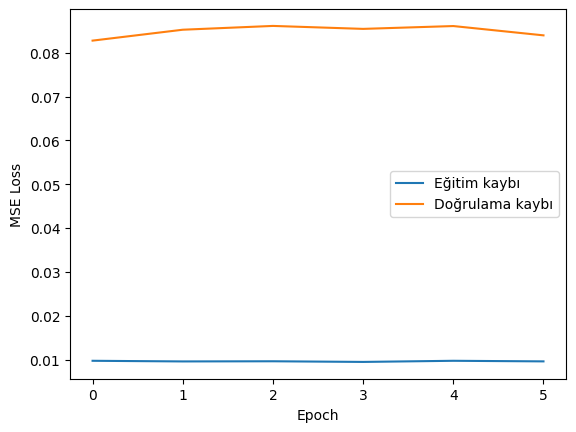

In [21]:
plt.plot(history.history['loss'], label='Eğitim kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama kaybı')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [23]:
import librosa.display
import soundfile as sf

# İlk segmenti al
decoded_segment = decoded_segments[0,...,0]

# Mel -> waveform
reconstructed_audio = librosa.feature.inverse.mel_to_audio(decoded_segment, sr=sr, n_fft=2048, hop_length=256)

# Dosyaya kaydet
sf.write("reconstructed.wav", reconstructed_audio, sr)